# Exercise 4: Tissue domains exploration with UTAG

## Objective
Use UTAG to discover spatially coherent tissue domains in the tumor microenvironment, evaluate the parameter setting and compare your result with SCIMAP.

---

## Clinical context
This exercise continues the high-grade serous ovarian cancer (HGSOC) case study from Exercise 3. In Exercise 3 you quantified immune–tumor proximity and cellular neighborhoods using scimap. Here, you can explore whether those local patterns form contiguous tissue structures that can be detected in an unsupervised way.

We focus on two treatment strategies that are associated with different immune landscapes:

| Strategy | Abbreviation | Description |
|---|---|---|
| Primary Debulking Surgery | PDS | Surgery first, then chemotherapy |
| Interval Debulking Surgery | IDS | Chemotherapy first to shrink the tumour, then surgery |

Patients are also stratified by homologous recombination (HR) status:

- BRCALoss: impaired DNA repair, often more therapy sensitive and potentially more immunogenic
- HRP: HR proficient tumors, often more resistant and less inflamed

In the study (Perez-Villatoro et al., 2026), certain treatment–genotype combinations produced strikingly different tumor–stroma interfaces (TSI), where immune cells either penetrate the tumor nests or remain confined to the boundary zone.

---

## What you will discover
You will compare two TMA cores that represent opposite ends of the immune infiltration spectrum:

| Core | Patient group |
|---|---|
| Core 84 | BRCALoss + PDS |
| Core 42 | HRP + IDS |

Key question: Can you detect differences in tumor microenvironment architecture computationally using only per-cell spatial coordinates and protein expression?

---

## Why UTAG for this question
Neighborhood features describe the local context around each cell. UTAG turns these local contexts into tissue-level structure by identifying spatially coherent domains. The output is a domain map that highlights microanatomical regions such as tumor nests, stromal bands, and interface-like zones, without requiring manual annotation.

Conceptually, UTAG does three things:
1. It constructs a spatial graph that defines which cells are neighbors.
2. It aggregates cellular features across neighbors to create spatially contextualized features.
3. It clusters these contextualized features to assign a domain label to each cell.

---

## Learning outcomes
By the end of this exercise you will be able to:

1. Construct a spatial neighbor graph and choose a reasonable distance cutoff for defining adjacency.
2. Run UTAG to compute domain labels and generate a tissue domain map.
3. Interpret domains using cell-type composition and marker profiles.
4. Compare domain-level architecture between two tissue cores using simple summary statistics.

---

## Workflow overview
```
Step 1 → Load AnnData, prepare spatial coordinates and subset cores  
Step 2 → Run UTAG (aggregate features and cluster into domains) on single slides. 
Step 3 → Visualize domain maps and compare Core 84 vs Core 42  
Step 4 → Adjust max_dist
Step 5 → Interpret domains using composition and marker signatures
Step 6 → Bonus: Compare SCIMAP and UTAG. 
```
---

## Step 1: Load the Data

In [18]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
adata = sc.read_h5ad('scimap_processed_single_cell_TMA_dataset.h5ad')

# Split the data for side-by-side comparison
tma8 = adata[adata.obs['imageid'] == 'TMA_8_core84'].copy()
tma1 = adata[adata.obs['imageid'] == 'TMA_1_core42'].copy()

print(f"Loaded {tma8.n_obs} cells for Core 84 and {tma1.n_obs} cells for Core 42.")

Loaded 3473 cells for Core 84 and 1799 cells for Core 42.


In [28]:
tma8

AnnData object with n_obs × n_vars = 3473 × 6
    obs: 'imageid', 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Perimeter', 'Roundness', 'phenotype', 'batch', 'spatial_cluster', 'spatial_community'
    uns: 'spatial_count', 'spatial_distance'
    obsm: 'spatial'

## Step 2: Run UTAG (aggregate features and cluster into domains) on single slides

In [8]:
from utag import utag

utag_single_results_8 = utag(
    tma8,
    slide_key="imageid",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.3]
)

utag_single_results_1 = utag(
    tma1,
    slide_key="imageid",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.3]
)

Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


Applying Leiden Clustering at Resolution: 0.3...
Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 15.12it/s]

Applying Leiden Clustering at Resolution: 0.3...


## Step 3: Visualize domain maps and compare Core 84 vs Core 42

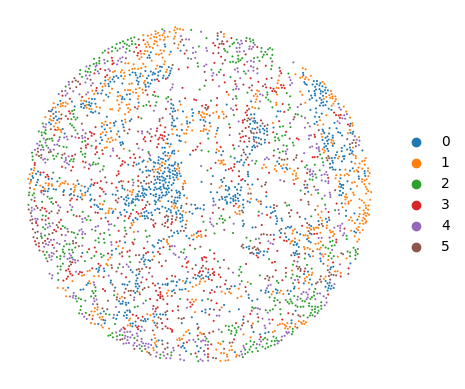

In [ ]:
sc.pl.spatial(utag_single_results_8, color = 'UTAG Label_leiden_0.3', spot_size = 10, title = '', frameon = False)

Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 15.47it/s]


Applying Leiden Clustering at Resolution: 0.3...


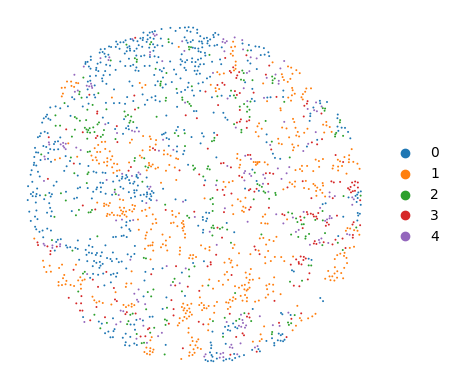

In [ ]:
sc.pl.spatial(utag_single_results_1, color = 'UTAG Label_leiden_0.3', spot_size = 10, title = '', frameon = False)

## Step 4: Adjust max_dist

In [19]:
## To be done by student based on step 2
## for example
results = utag(
    tma1,
    slide_key="imageid",
    max_dist=15,
    normalization_mode='l1_norm',
    apply_clustering=True,
    clustering_method = 'leiden', 
    resolutions = [0.2]
)

Applying UTAG Algorithm...


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 16.92it/s]

Applying Leiden Clustering at Resolution: 0.2...


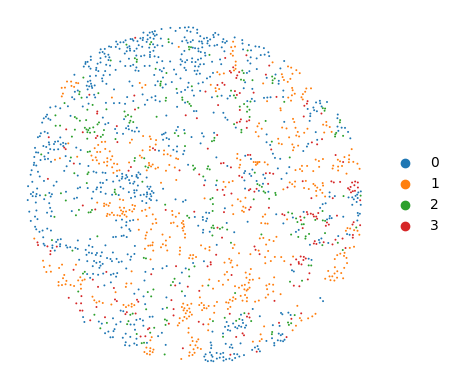

In [15]:
sc.pl.spatial(results, color = 'UTAG Label_leiden_0.2', spot_size = 10, title = '', frameon = False)

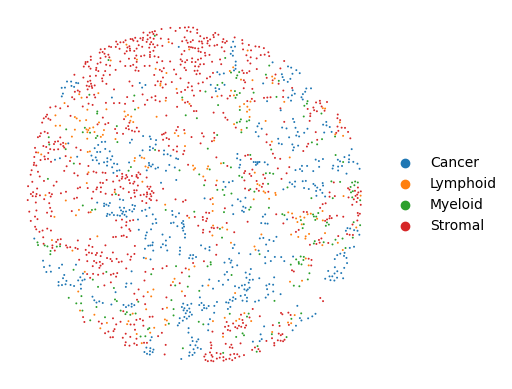

In [16]:
sc.pl.spatial(results, color = 'phenotype', spot_size = 10, title = '', frameon = False)

## Step 5: Interpret domains using composition and marker signatures

In [ ]:
cm = sns.clustermap(results.to_df().corr(), cmap="coolwarm", vmin=-1, vmax=1)
var_order = results.var.iloc[cm.dendrogram_col.reordered_ind].index

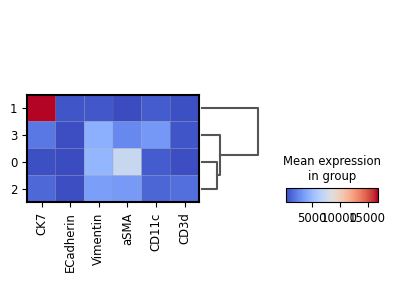

In [ ]:
# TODO- normalize the marker expression
sc.pl.matrixplot(
    results,
    var_names = var_order, 
    groupby="UTAG Label_leiden_0.2",
    dendrogram=True,
    cmap="coolwarm",
    show=True,
)

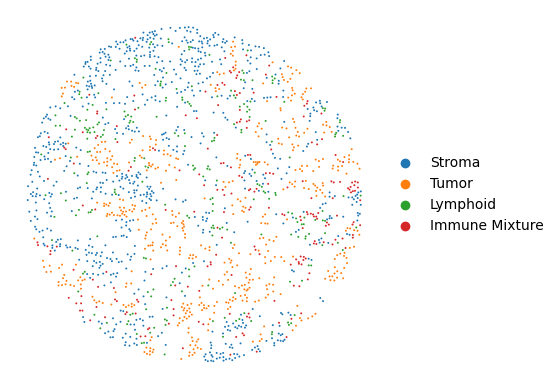

In [36]:
mapper = {
    '0': 'Stroma', 
    '1': 'Tumor', 
    '2': 'Lymphoid',
    '3': 'Immune Mixture', 
}

results.obs['UTAG Label'] = pd.Categorical(results.obs['UTAG Label_leiden_0.2'])
results.obs['T/S'] = pd.Categorical(results.obs['UTAG Label_leiden_0.2'].replace(mapper))
sc.pl.spatial(results, color = 'T/S', spot_size = 10, title = '', frameon = False)

## Step 6: (Bonus) Compare SCIMAP and UTAG results